In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5324.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3382.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1398.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1142.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5002.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2646.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3476.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1613.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5593.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2975.BMP
/kaggle/input/finger-print-based-blood-g

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
dataset_path = '/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group'

In [4]:
BATCH_SIZE = 32

In [5]:
## Step 1 : Load Dataset 
dataset = image_dataset_from_directory (
    dataset_path , 
    labels = 'inferred' ,
    label_mode = 'int' ,
    image_size = (64,64) ,
    batch_size = BATCH_SIZE ,
    shuffle = True
)

Found 6000 files belonging to 8 classes.


In [6]:
# Step 2: Check class distribution
class_names = dataset.class_names
class_counts = Counter()

for _, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")


Class Distribution:
O-: 712
B-: 741
A+: 565
A-: 1009
AB+: 708
AB-: 761
O+: 852
B+: 652


In [7]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
    """
    Plots the distribution of classes in the dataset.

    Parameters:
    - class_names (list): List of class names.
    - class_counts (dict): Dictionary with class indices as keys and counts as values.

    Returns:
    - None
    """

    # Extract class names and their corresponding counts
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Class Names")
    plt.ylabel("Count")
    plt.title("Class Distribution in Dataset")
    plt.xticks(rotation=45)
    plt.show()


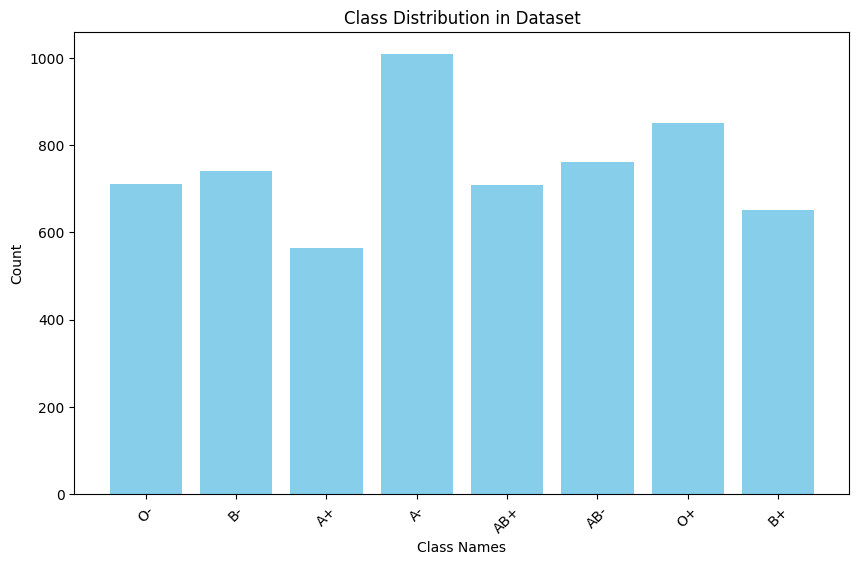

In [8]:
plot_class_distribution(class_names , class_counts)

In [9]:
max_count = max(class_counts.values())

In [10]:
# Function to oversample a class
def oversample_class(class_id, count, max_count):
    # Ensure the dataset is unbatched for filtering
    unbatched_dataset = dataset.unbatch()

    # Filter the dataset for the specific class
    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

    # Calculate the number of repetitions needed
    repeat_factor = max_count // count + (max_count % count > 0)

    # Repeat the dataset to match the desired count
    return class_dataset.repeat(repeat_factor).take(max_count)

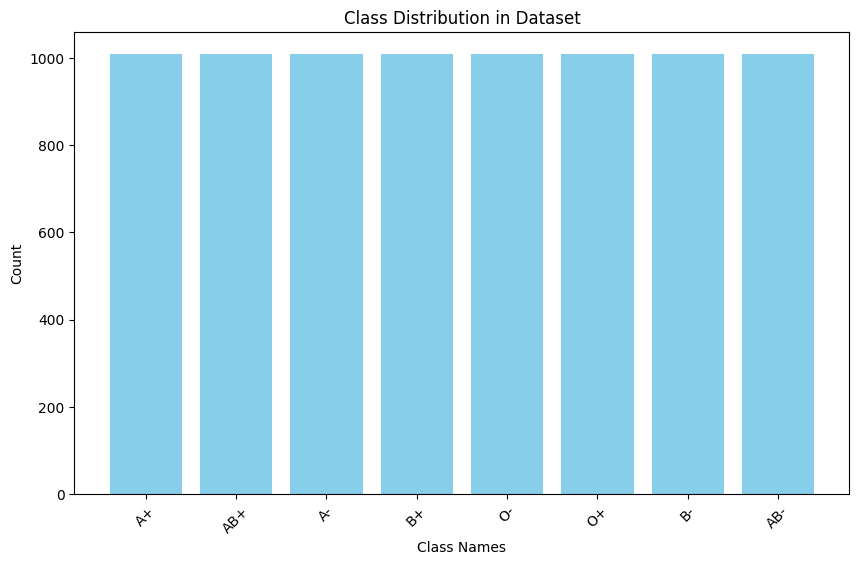

In [11]:
# Step 1: Balance the dataset
balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))

# Step 2: Combine balanced datasets
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

# Step 3: Check balanced class distribution
balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)

# Step 4: Batch the balanced dataset
balanced_dataset = balanced_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
for sample in balanced_dataset.take(10) :
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [13]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size : {dataset_size} ")

Total dataset size : 8064 


In [14]:
# Unbatch the dataset to work at the sample level  
balanced_dataset_unbatched = balanced_dataset.unbatch()  

# Define the ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio  # 0.1

# Compute sizes based on dataset size and desired splits  
dataset_size = sum(1 for _ in balanced_dataset_unbatched)  # Calculate the total dataset size
train_size = int(train_ratio * dataset_size)  
val_size = int(val_ratio * dataset_size)  
test_size = dataset_size - train_size - val_size  # Remaining for test

# Split the dataset into training, validation, and test  
train_dataset = balanced_dataset_unbatched.take(train_size)  
val_test_dataset = balanced_dataset_unbatched.skip(train_size)  
val_dataset = val_test_dataset.take(val_size)  
test_dataset = val_test_dataset.skip(val_size)  

# Rebatch the datasets after splitting  
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)  
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)  
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)  

# Check the number of batches in each dataset  
train_batch_count = sum(1 for _ in train_dataset)  
val_batch_count = sum(1 for _ in val_dataset)  
test_batch_count = sum(1 for _ in test_dataset)  

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")  
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")  
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")

Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


In [15]:
import tensorflow as tf

def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),  # Corrected typo here
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(len(class_names) , activation = 'softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Example usage:
high_acc_model = create_high_accuracy_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss
    factor=0.5,            # Reduce the learning rate by a factor of 0.5
    patience=3,            # Wait for 3 epochs without improvement before reducing LR
    verbose=1,             # Print a message when the learning rate is reduced
    min_lr=1e-6            # Minimum learning rate to avoid too small values
)

# Define EarlyStopping callback to stop training when validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Stop after 5 epochs without improvement
    verbose=1,             # Print a message when training is stopped
    restore_best_weights=True  # Restore the model weights from the best epoch
)


In [17]:
history_high_acc = high_acc_model.fit(
    train_dataset ,
    validation_data = val_dataset ,
    epochs = 50 , 
    callbacks = [reduce_lr , early_stop]
)

Epoch 1/50
    176/Unknown 28s 100ms/step - accuracy: 0.1285 - loss: 27.6849

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 236ms/step - accuracy: 0.1285 - loss: 27.5717 - val_accuracy: 0.1244 - val_loss: 2.0800 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.1273 - loss: 2.0824 - val_accuracy: 0.1175 - val_loss: 2.0776 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.2207 - loss: 1.9681 - val_accuracy: 0.2019 - val_loss: 1.9701 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 40s 225ms/step - accuracy: 0.3316 - loss: 1.7424 - val_accuracy: 0.2675 - val_loss: 1.8030 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 39s 220ms/step - accuracy: 0.4238 - loss: 1.4787 - val_accuracy: 0.5556 - val_loss: 1.4991 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 39s 222ms/step - accuracy: 0.5848 - loss: 1.0961 - val_accuracy: 0.6594 - val_loss: 1.1257 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 39s 222ms/step - accuracy: 0.6683 - loss

In [18]:
high_acc_eval = high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss : {high_acc_eval[0]} , Accuracy : {high_acc_eval[1]}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - accuracy: 0.9230 - loss: 0.3277
High Accuracy Model - Loss : 0.33480122685432434 , Accuracy : 0.9193750023841858


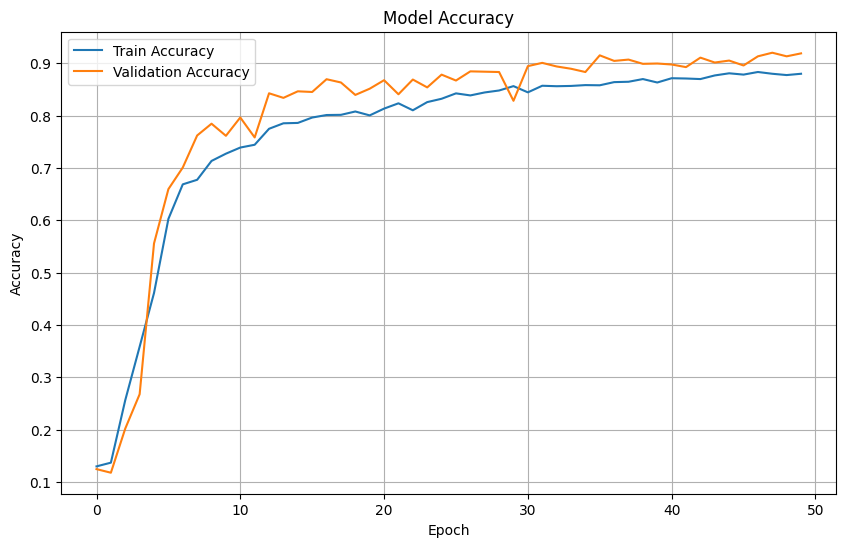

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
def plot_accuracy(history):
    """
    Plots the training and validation accuracy over epochs.

    Parameters:
    history (keras.callbacks.History): The history object returned by model.fit().
    """
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)  # Add grid for better readability
    plt.show()

# Example usage:
# Assuming `history_high_acc` is the history object returned by model.fit()

plot_accuracy(history_high_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Classification Report:
              precision   

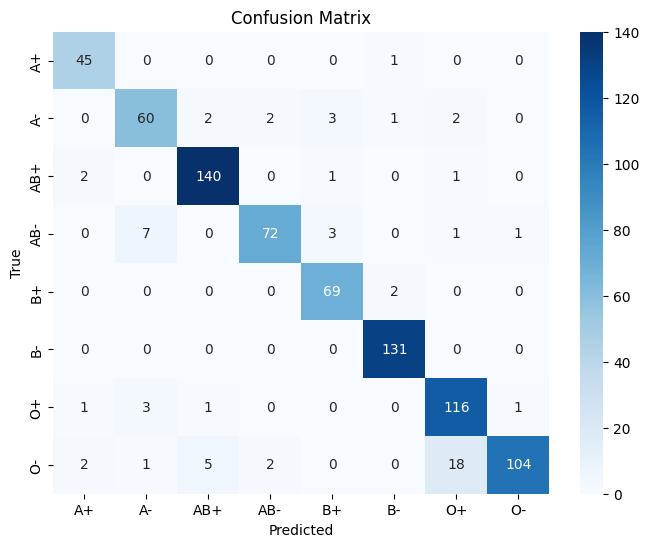

In [21]:
import numpy as np
from sklearn.metrics import classification_report

# Get predictions on the test dataset
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to class labels
    y_true.extend(labels.numpy())  # Convert tensor to numpy array and append
    y_pred.extend(predicted_labels)  # Append the predicted labels

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
high_acc_model.save('model.h5')
print('model saved as HDFS Format.')

model saved as HDFS Format.
